In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import time
import re
import os
import asyncio
import json
import nltk
import random

from parallel_reddit_scrape import Scraper
import dotenv

from dotenv import load_dotenv

load_dotenv()

True

# Redditverse Analysis

Firstly, we're going to need to define our search targets. We want to pull data from different parts of reddit.

We'll use simple json links to retrieve reddit page data, and then iterate through the results.

This is setting up our data for our analysis.

Goal: Come up with an approach and a method of testing to validate your approach along the way. Identify the challenges that will arise on taking on this project. 

### But first, we need to create an example dataset

In [2]:
# this will get us all the URLs we need to start pulling reddit data

limit = 500
timeframe = 'year' #hour, day, week, month, year, all
listing = 'relevance' # controversial, best, hot, new, random, rising, top

topics = ['blockchain', 'defi', 'digital assets', 'NFT', 'cryptocurrency', 'crypto', 'blockchain development','blockchain network', 'crypto exchange']
companies = [
 'Mojito',
 'TaxBit',
 'ConsenSys Software Inc',
 'BlockFi',
 'Bitfury',
 'Blockdaemon',
 'RECUR',
 'Chainalysis',
 'Coinbase',
 'Unstoppable Domains',
 'Coinme Inc.',
 'Axoni',
 'Paxful',
 'IBM',
 'Republic',
 'Spring Labs',
 'Galaxy',
 'SALT',
 'Mythical Games',
 'Anchorage Digital',
 'Robinhood',
 'Lemonade',
 'Circle',
 'Algorand',
 'Paxos',
 'Ripple',
 'Lockheed Martin',
 'Nium',
 'Ford Motor Company',
 'TQ Tezos',
 'BRD',
 'NYDIG',
 'BitMEX',
 'Netki',
 'Celsius',
 'Nisum',
 'Bloq',
 'doc.ai',
 'MoonPay',
 'TrustToken',
 'Oasis Labs',
 'Chronicled',
 'High Fidelity',
 'ANKR',
 'VOATZ',
 'STEEM',
 'Omega Grid',
 'Filecoin',
 'Mediachain',
 'ShipChain']

comp_urls = []
topic_urls = []
for comp in companies:
    comp = comp.replace(' ', '%20')
    comp_urls.append(f'https://www.reddit.com/search.json?q={comp}&limit={limit}&t={timeframe}&sort={listing}&type=link')
    topic_urls.append(f'https://www.reddit.com/search.json?q={comp}&limit={limit}&t={timeframe}&sort={listing}&type=sr')
for topic in topics: 
    topic = topic.replace(' ', '%20')
    topic_urls.append(f'https://www.reddit.com/search.json?q={topic}&limit={limit}&t={timeframe}&sort={listing}&type=sr')

In [3]:
# we want to set up a NLP model to analyze our text with (as a rough approximation)
# in preparation for this, we need to create a function that will tokenize strings into sentences.

# We'll use NLTK's pretrained VADER model (which is good for social media analysis) as a simple sentiment model our textual data
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()


def get_compound(string: str):
    if string == '':
        return 0
    scores = [sia.polarity_scores(sentence)['compound'] for sentence in nltk.sent_tokenize(string)]
    return np.nanmean(scores)


### First, we'll find out where the content we want to look at is being posted

Then we can filter to the select columns that are relevant to the goal

In [4]:
scrape_communities = Scraper()
df = scrape_communities.reddit_function(topic_urls)
df[['id','created_utc','url','display_name','public_description','subreddit_type','advertiser_category','community_reviewed','subscribers','accounts_active']]

,id,created_utc,url,display_name,public_description,subreddit_type,advertiser_category,community_reviewed,subscribers,accounts_active
0,2s3qj,1.284043e+09,/r/Bitcoin/,Bitcoin,Bitcoin is the currency of the Internet: a dis...,public,Business / Finance,True,4656976.0,None
1,2si5v,1.305886e+09,/r/btc/,btc,When r/Bitcoin moderators began censoring cont...,public,,True,1054564.0,None
2,3x9vj5,1.612774e+09,/r/hut8/,hut8,Hut 8 Mining Corp. $hut $hut.to,public,,True,4628.0,None
3,2wlj3,1.363039e+09,/r/CryptoCurrency/,CryptoCurrency,"The leading community for cryptocurrency news,...",public,Business / Finance,True,5601587.0,None
4,2skbb,1.308155e+09,/r/BitcoinMining/,BitcoinMining,The official bitcoin mining forum / subreddit ...,public,Technology,True,88190.0,None
...,...,...,...,...,...,...,...,...,...,...
48,35ity,1.419256e+09,/r/ledgerwallet/,ledgerwallet,Discussions about Ledger's products. Visit us ...,public,,True,93149.0,None
49,3khaf,1.495044e+09,/r/Ripplemarket/,Ripplemarket,The Ripple Marketplace. For those looking to b...,private,None,None,NaN,None
50,4uijwt,1.627958e+09,/r/RippletheOffGridCOOP/,RippletheOffGridCOOP,This is a group to organize likeminded individ...,restricted,,True,227.0,None
51,311c3,1.395441e+09,/r/ripplenetwork/,ripplenetwork,Ripple Network Official Subreddit,public,,False,94.0,None


In [5]:
# then we apply some basic transformations to filter the data slightly and get a more accurate result

subreddits = df[['id','url','display_name','public_description','description_html', 'subreddit_type','advertiser_category','community_reviewed','subscribers','accounts_active']]
subreddits = subreddits[(subreddits['public_description'].str.contains(pat=r'blockchain|crypto|defi |digital asset|nft', case=False)) & (subreddits['subscribers'] > 500)].drop_duplicates()
subreddits

,id,url,display_name,public_description,description_html,subreddit_type,advertiser_category,community_reviewed,subscribers,accounts_active
1,2si5v,/r/btc/,btc,When r/Bitcoin moderators began censoring cont...,&amp;lt;!-- SC_OFF --&amp;gt;&amp;lt;div class...,public,,True,1054564.0,None
3,2wlj3,/r/CryptoCurrency/,CryptoCurrency,"The leading community for cryptocurrency news,...",&amp;lt;!-- SC_OFF --&amp;gt;&amp;lt;div class...,public,Business / Finance,True,5601587.0,None
3,42kuwz,/r/SafeMoon/,SafeMoon,SafeMoon is a human-focused technology and inn...,&amp;lt;!-- SC_OFF --&amp;gt;&amp;lt;div class...,public,,True,299945.0,None
26,9e4pv,/r/CryptoMoonShots/,CryptoMoonShots,This subreddit is a place to discuss low marke...,&amp;lt;!-- SC_OFF --&amp;gt;&amp;lt;div class...,public,,True,1858488.0,None
27,4756xs,/r/NICHEMAN/,NICHEMAN,"Welcome to Nicheman, your new favorite niche c...",&amp;lt;!-- SC_OFF --&amp;gt;&amp;lt;div class...,public,,False,788.0,None
...,...,...,...,...,...,...,...,...,...,...
3,m6nxb,/r/cocosbcx/,cocosbcx,Official group for Cocos-BCX (Cocos Blockchain...,None,restricted,,True,1554.0,None
0,4bjjz,/r/chronicled/,chronicled,Open community for discussions about blockchai...,&amp;lt;!-- SC_OFF --&amp;gt;&amp;lt;div class...,public,,False,5699.0,None
46,32llw,/r/Coinpot/,Coinpot,r/coinpot is a subreddit for the discussion of...,&amp;lt;!-- SC_OFF --&amp;gt;&amp;lt;div class...,public,,True,1930.0,None
47,2zwxw,/r/DogeNews/,DogeNews,A subreddit that will bring you the latest Dog...,&amp;lt;!-- SC_OFF --&amp;gt;&amp;lt;div class...,public,Technology,True,6376.0,None


### Before finishing with our first table, we want to add some sentiment modeling for further analysis later on

We'll do so with NLTK and their VADER model

In [6]:


# first, let's just pull our text related information out of the main table
subreddit_descriptions = subreddits[['id','display_name','public_description']].rename(columns={'id':'subreddit_id'}).reset_index().drop('index',axis=1).set_index('subreddit_id')

# then we'll iterate through the table, creating a new list to store the sentiment data.

subreddit_descriptions['subreddit_sentiment'] = [get_compound(description) for description in subreddit_descriptions['public_description']]

# we also want to create a list to filter the posts submissions on in the next section
subreddit_list = subreddits['display_name'].unique().tolist()

subreddit_descriptions


,display_name,public_description,subreddit_sentiment
subreddit_id,,,
2si5v,btc,When r/Bitcoin moderators began censoring cont...,0.194925
2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",0.000000
42kuwz,SafeMoon,SafeMoon is a human-focused technology and inn...,0.636900
9e4pv,CryptoMoonShots,This subreddit is a place to discuss low marke...,-0.105000
4756xs,NICHEMAN,"Welcome to Nicheman, your new favorite niche c...",0.367867
...,...,...,...
m6nxb,cocosbcx,Official group for Cocos-BCX (Cocos Blockchain...,0.000000
4bjjz,chronicled,Open community for discussions about blockchai...,0.526700
32llw,Coinpot,r/coinpot is a subreddit for the discussion of...,0.177900


### Now that we have our communities, we can query reddit for all posts related to our company list

In [7]:
scrape_posts = Scraper()
gf = scrape_posts.reddit_function(comp_urls)

In [8]:
posts = gf[['id','company','created','author','title','selftext','category','content_categories','subreddit','subreddit_id','score','upvote_ratio','total_awards_received','num_comments','num_crossposts','permalink']]
len(posts)
posts = posts[posts['subreddit'].isin(subreddit_list)] # Make sure we only are getting posts from subreddits we are interested in.
posts['json_link'] = ['https://reddit.com' + x + '.json' for x in posts['permalink'].to_list()]
posts = posts[posts['score'].gt(50)].sort_values(by='score', ascending=False)
posts = posts.reset_index().drop('index',axis=1)
posts['subreddit_id'] = posts['subreddit_id'].replace(r'.._', '', regex=True)
posts['selftext'] = posts['selftext'].str.replace('\n', ' ').str.replace('*', '')
posts

/var/folders/9k/r_3qnbt90jj4607x_x98wv840000gn/T/ipykernel_37044/1079295923.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  posts['selftext'] = posts['selftext'].str.replace('\n', ' ').str.replace('*', '')


,id,company,created,author,title,selftext,category,content_categories,subreddit,subreddit_id,score,upvote_ratio,total_awards_received,num_comments,num_crossposts,permalink,json_link
0,w4jflp,Coinbase,1.658417e+09,dragondude4,A Coinbase Product Manager was Just Charged Wi...,From the Justice Department: Beginning in app...,None,None,CryptoCurrency,2wlj3,7520,0.96,15,1076,10,/r/CryptoCurrency/comments/w4jflp/a_coinbase_p...,https://reddit.com/r/CryptoCurrency/comments/w...
1,xxv8kn,Celsius,1.665138e+09,itcouldbefrank,The saga that keeps on giving: Celsius publish...,As part of their bankruptcy legal proceedings ...,None,None,CryptoCurrency,2wlj3,5678,0.92,15,1256,11,/r/CryptoCurrency/comments/xxv8kn/the_saga_tha...,https://reddit.com/r/CryptoCurrency/comments/x...
2,y5gp3p,Lemonade,1.665926e+09,JackOfAllInterests1,Non binary lemonade rule,,None,None,196,2v92f,4691,1.00,0,53,0,/r/196/comments/y5gp3p/non_binary_lemonade_rule/,https://reddit.com/r/196/comments/y5gp3p/non_b...
3,vygvf1,Celsius,1.657754e+09,alphabravoccharlie,Celsius informs state regulators that it's fil...,,None,None,CryptoCurrency,2wlj3,4115,0.94,9,1234,4,/r/CryptoCurrency/comments/vygvf1/celsius_info...,https://reddit.com/r/CryptoCurrency/comments/v...
4,w1dls7,Coinbase,1.658082e+09,Oscar_G_13,"""Too big to fail"" does not exist for Coinbase ...",This subreddit has been riddled with warning a...,None,None,CryptoCurrency,2wlj3,3898,0.84,16,1013,2,/r/CryptoCurrency/comments/w1dls7/too_big_to_f...,https://reddit.com/r/CryptoCurrency/comments/w...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,ycltjb,Algorand,1.666644e+09,HashMapsData2Value,"Jack Chan, previously part of HarmonyOne's cor...",,None,None,AlgorandOfficial,wm2x2,52,0.96,0,8,0,/r/AlgorandOfficial/comments/ycltjb/jack_chan_...,https://reddit.com/r/AlgorandOfficial/comments...
212,r121h3,TrustToken,1.637749e+09,johnarcherito,GreenTrust Token will make a new Farm on Panca...,GNT to the moon with the today farm on Pancak...,None,None,shitcoinmoonshots,44md7l,52,1.00,0,10,0,/r/shitcoinmoonshots/comments/r121h3/greentrus...,https://reddit.com/r/shitcoinmoonshots/comment...
213,y90kza,Algorand,1.666278e+09,estantef,"[AMA] Vendible, a privacy-preserving identity ...",EDIT #1: WE ARE LIVE! EDIT #2: Thank you Vend...,None,None,AlgorandOfficial,wm2x2,51,1.00,0,101,4,/r/AlgorandOfficial/comments/y90kza/ama_vendib...,https://reddit.com/r/AlgorandOfficial/comments...
214,r0j6j1,TrustToken,1.637691e+09,johnarcherito,GreenTrust Token will make a new Farm on Panca...,GNT to the moon!! GreenTrust token just win ...,None,None,BSCMoonShots,3z9zp0,51,1.00,0,8,0,/r/BSCMoonShots/comments/r0j6j1/greentrust_tok...,https://reddit.com/r/BSCMoonShots/comments/r0j...


More sentiment analysis for later

In [9]:
# pulling out some more text so that we can use it in the sentiment analysis
# again we'll create some sentiment columns for later analysis

post_text = posts[['id','subreddit_id','title','selftext']].reset_index().drop('index',axis=1).set_index('id')

#get sentiment scores for the text columns
post_text['title_sentiment'] = [get_compound(title) for title in post_text['title']]
post_text['selftext_sentiment'] = [get_compound(selftext) for selftext in post_text['selftext']]

post_text


,subreddit_id,title,selftext,title_sentiment,selftext_sentiment
id,,,,,
w4jflp,2wlj3,A Coinbase Product Manager was Just Charged Wi...,From the Justice Department: Beginning in app...,-0.5994,0.260652
xxv8kn,2wlj3,The saga that keeps on giving: Celsius publish...,As part of their bankruptcy legal proceedings ...,0.3400,-0.070312
y5gp3p,2v92f,Non binary lemonade rule,,0.0000,0.000000
vygvf1,2wlj3,Celsius informs state regulators that it's fil...,,0.0000,0.000000
w1dls7,2wlj3,"""Too big to fail"" does not exist for Coinbase ...",This subreddit has been riddled with warning a...,-0.6010,-0.308086
...,...,...,...,...,...
ycltjb,wm2x2,"Jack Chan, previously part of HarmonyOne's cor...",,0.0000,0.000000
r121h3,44md7l,GreenTrust Token will make a new Farm on Panca...,GNT to the moon with the today farm on Pancak...,0.0000,0.177427
y90kza,wm2x2,"[AMA] Vendible, a privacy-preserving identity ...",EDIT #1: WE ARE LIVE! EDIT #2: Thank you Vend...,0.0000,0.197730


# After filtering our posts, we can start to scrape all the comments on each of those posts.
### These comments will hopefully be useful for providing sentiment on the posts themselves.

We can use the json link I formatted earler to get all the post details

In [10]:
scrape_comments = Scraper()
jsonlinks = posts['json_link'].to_list() # list from our posts DataFrame
comments = scrape_comments.get_many_jsons(jsonlinks)

### We need to create a recursive function to parse all the replies from each comment thread json response

In [11]:


def more_replies(d, depth = 1, r = [], score = 0):
    if d == '':
        return (r, depth, score)
    elif isinstance(d, dict):
        replies = d['data']['children']
        for re in replies:
            if re['kind'] != 't1':
                continue
            reply = re['data']
            r.append(reply['author'] + ': ' + reply['body'])
            score += reply['score']
            if reply['replies'] != '':
                depth += 1
                more_replies(reply['replies'], depth, r)
        return (r, depth, score)


Now we can sort through the comment data to create an additional layer of detail for each post

In [12]:
#parsing the data and creating a DataFrame from the results

coms = comments
comm_dict = []
for com in coms:
    if not com:
        continue
    if len(com) != 2:
        continue
    comment_section_= com[1]['data']['children']

    # set up dictionary for tracking comments and comment replies per post
    for commenties in comment_section_:
        post_comments = {}
        post_comments['original_post_id'] = com[0]['data']['children'][0]['data']['id']
        post_comments['num_comments'] = len(comment_section_)
        if commenties['kind'] != 't1':
            continue
        comment = commenties['data']
        post_comments['comment_id'] = comment['id']
        post_comments['awards'] = comment['total_awards_received']
        post_comments['score'] = comment['score']
        post_comments['comment'] = comment['author'] + ': ' + comment['body']
        if comment['replies'] != '':
            reps = more_replies(comment['replies'], depth = 1, r = [])
            reply_text = '. '.join(reps[0]).replace('\n', '. ')
            post_comments['replies'] = reply_text
            post_comments['reply_score'] = reps[2]
            post_comments['thread'] = post_comments['comment'] + ' --- ' + reply_text
            token_thread = [reply.replace('\n','. ') for reply in reps[0]]
            token_thread.insert(0,post_comments['comment'])
            post_comments['tokenized_thread'] = token_thread
            post_comments['max_depth'] = reps[1]
        else:
            post_comments['replies'] = ''
            post_comments['reply_score'] = 0
            post_comments['thread'] = post_comments['comment']
            post_comments['max_depth'] = 0
            post_comments['tokenized_thread'] = [post_comments['comment']]
        comm_dict.append(post_comments)

comment_section = pd.DataFrame(comm_dict)
comment_section.drop_duplicates(subset='comment_id',keep='first').reset_index().drop('index',axis=1)

,original_post_id,num_comments,comment_id,awards,score,comment,replies,reply_score,thread,max_depth,tokenized_thread
0,y30yf6,19,is5vug6,0,49,"ValsinatsKrrt: Thank you, this is the hopium i...",,0,"ValsinatsKrrt: Thank you, this is the hopium i...",0,"[ValsinatsKrrt: Thank you, this is the hopium ..."
1,y30yf6,19,is5zl58,0,39,FormerPomegranate325: Sweet sweet hopium,,0,FormerPomegranate325: Sweet sweet hopium,0,[FormerPomegranate325: Sweet sweet hopium]
2,y30yf6,19,is66lvl,0,32,notyourbroguy: Post this in r/cc if you’re ok ...,"Efficient_Lab_9605: ""Pfft. Algorand. Just anot...",5,notyourbroguy: Post this in r/cc if you’re ok ...,2,[notyourbroguy: Post this in r/cc if you’re ok...
3,y30yf6,19,is66rlm,0,32,Certain_Cranberry_77: SBF is gonna announce a ...,UsernameIWontRegret: Ah yes my favorite source...,32,Certain_Cranberry_77: SBF is gonna announce a ...,2,[Certain_Cranberry_77: SBF is gonna announce a...
4,y30yf6,19,is6zhmj,0,11,"HashMapsData2Value: Yup, we're all super excit...",,0,"HashMapsData2Value: Yup, we're all super excit...",0,"[HashMapsData2Value: Yup, we're all super exci..."
...,...,...,...,...,...,...,...,...,...,...,...
5864,wqjxrf,40,ikol61i,0,1,"Leading_Economics_79: lol, gullible noobs.",,0,"Leading_Economics_79: lol, gullible noobs.",0,"[Leading_Economics_79: lol, gullible noobs.]"
5865,wqjxrf,40,ikoois7,0,1,BrowsingCoins: well I have been getting fewer ...,,0,BrowsingCoins: well I have been getting fewer ...,0,[BrowsingCoins: well I have been getting fewer...
5866,wqjxrf,40,ikpl8or,0,1,Goonzoo: u/gulliblenoob is raging,,0,Goonzoo: u/gulliblenoob is raging,0,[Goonzoo: u/gulliblenoob is raging]
5867,wqjxrf,40,ikqj4xe,0,1,BenniBoom707: Canon Fodder 🤦🏻‍♂️,,0,BenniBoom707: Canon Fodder 🤦🏻‍♂️,0,[BenniBoom707: Canon Fodder 🤦🏻‍♂️]


More sentiment analysis again

In [13]:
# now we can grab the all the comment text data from the posts comments table

comment_threads_text = comment_section[['original_post_id','comment_id','thread','tokenized_thread']].drop_duplicates(subset='comment_id').reset_index().drop(labels='index', axis=1).set_index('original_post_id')

# [~comment_section['thread'].str.contains(r'bot|deleted', case=False, flags=re.IGNORECASE)]
#get comment thread sentiment scores
comment_threads_text['thread_sentiment'] = [np.nanmean([get_compound(re.sub(r'.*:','',comment)) for comment in list_of_comments]) for list_of_comments in comment_threads_text['tokenized_thread']]

comment_threads_text

,comment_id,thread,tokenized_thread,thread_sentiment
original_post_id,,,,
y30yf6,is5vug6,"ValsinatsKrrt: Thank you, this is the hopium i...","[ValsinatsKrrt: Thank you, this is the hopium ...",0.419900
y30yf6,is5zl58,FormerPomegranate325: Sweet sweet hopium,[FormerPomegranate325: Sweet sweet hopium],0.718400
y30yf6,is66lvl,notyourbroguy: Post this in r/cc if you’re ok ...,[notyourbroguy: Post this in r/cc if you’re ok...,0.129163
y30yf6,is66rlm,Certain_Cranberry_77: SBF is gonna announce a ...,[Certain_Cranberry_77: SBF is gonna announce a...,0.488030
y30yf6,is6zhmj,"HashMapsData2Value: Yup, we're all super excit...","[HashMapsData2Value: Yup, we're all super exci...",0.111750
...,...,...,...,...
wqjxrf,ikol61i,"Leading_Economics_79: lol, gullible noobs.","[Leading_Economics_79: lol, gullible noobs.]",0.077200
wqjxrf,ikoois7,BrowsingCoins: well I have been getting fewer ...,[BrowsingCoins: well I have been getting fewer...,0.125000
wqjxrf,ikpl8or,Goonzoo: u/gulliblenoob is raging,[Goonzoo: u/gulliblenoob is raging],-0.526700


# We now have a good source of data that we can analyze


The main focus first is the analysis of the text data
- subreddit descriptions
- post texts
- post comment threads

In [14]:
# first we can set up a few different wordlists
reddit_text = post_text.join(comment_threads_text, how='left').drop_duplicates(subset='comment_id', keep='first').reset_index().rename(columns={'index':'post_id'})

reddit_corpus = reddit_text.merge(subreddit_descriptions, on='subreddit_id', how='left').drop_duplicates(subset=['subreddit_id','post_id','comment_id'],keep='first').reset_index().drop(labels='index',axis=1)

reddit_corpus = reddit_corpus[reddit_corpus['comment_id'].notna() & reddit_corpus['comment_id'].notna() & reddit_corpus['comment_id'].notna()].reset_index().drop(labels='index',axis=1)

reddit_corpus['id'] = reddit_corpus['subreddit_id'] + '-' + reddit_corpus['post_id'] + '-' + reddit_corpus['comment_id']
reddit_corpus = reddit_corpus[['id','subreddit_id','display_name','public_description','subreddit_sentiment','post_id','title','title_sentiment','selftext','selftext_sentiment','comment_id','thread','thread_sentiment']].set_index('id')

reddit_corpus

,subreddit_id,display_name,public_description,subreddit_sentiment,post_id,title,title_sentiment,selftext,selftext_sentiment,comment_id,thread,thread_sentiment
id,,,,,,,,,,,,
2wlj3-qvyw0n-hkznnab,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",0.000,qvyw0n,"We are Oasis - the leading privacy-enabled, la...",0.189975,"# Greetings, r/cryptocurrency! We are the [O...",0.431433,hkznnab,Revolutionary-Pen-45: How do you see ROSE bein...,0.118875
2wlj3-qvyw0n-hkzld9l,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",0.000,qvyw0n,"We are Oasis - the leading privacy-enabled, la...",0.189975,"# Greetings, r/cryptocurrency! We are the [O...",0.431433,hkzld9l,faranwkh: Privacy is your main concern. You ha...,0.189114
2wlj3-qvyw0n-hkzg3b2,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",0.000,qvyw0n,"We are Oasis - the leading privacy-enabled, la...",0.189975,"# Greetings, r/cryptocurrency! We are the [O...",0.431433,hkzg3b2,HeWhoDares18: Can you implement a solution to ...,0.210020
2wlj3-qvyw0n-hkzj4wn,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",0.000,qvyw0n,"We are Oasis - the leading privacy-enabled, la...",0.189975,"# Greetings, r/cryptocurrency! We are the [O...",0.431433,hkzj4wn,Mobile-Philosophy-83: Will Yuzuswap's team mak...,0.220200
2wlj3-qvyw0n-hkznpal,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",0.000,qvyw0n,"We are Oasis - the leading privacy-enabled, la...",0.189975,"# Greetings, r/cryptocurrency! We are the [O...",0.431433,hkznpal,BigschnozerSmolpeepe: How can i buy this token...,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2z2wm-yd2xc3-itqfnf6,2z2wm,CryptoMarkets,Crypto Market Analysis &amp;amp; Discussion.\n...,-0.064,yd2xc3,"I’m leaving Coinbase and Crypto.com, what are ...",0.636900,"I've been a Coinbase user for over 2 years, bu...",0.127194,itqfnf6,Dr_ishmex: Binance and Kucoin for me,0.000000
2z2wm-yd2xc3-itqgzcx,2z2wm,CryptoMarkets,Crypto Market Analysis &amp;amp; Discussion.\n...,-0.064,yd2xc3,"I’m leaving Coinbase and Crypto.com, what are ...",0.636900,"I've been a Coinbase user for over 2 years, bu...",0.127194,itqgzcx,DeckerR: Ledger. Or a paper wallet.,0.000000
2z2wm-yd2xc3-itqmg02,2z2wm,CryptoMarkets,Crypto Market Analysis &amp;amp; Discussion.\n...,-0.064,yd2xc3,"I’m leaving Coinbase and Crypto.com, what are ...",0.636900,"I've been a Coinbase user for over 2 years, bu...",0.127194,itqmg02,Supercc: I'm using binance for most of my need...,-0.592700


### Validating that our text data appears to show relevant data

We can look at the resulting full corpus and see what common Trigrams appear

This is a quick way to see if our corpus contains content roughly in the same genre of what we are looking for

In [15]:
# first we need to clean up the word list and tokenize the words
thread_c = reddit_corpus[~reddit_corpus['thread'].str.contains(r'automoderator|bot|action performed|deleted', '', flags=re.IGNORECASE)]['thread'].dropna().unique().tolist()
thread_t = reddit_corpus[~reddit_corpus['title'].str.contains(r'bot|action performed automatically', '', flags=re.IGNORECASE)]['title'].dropna().unique().tolist()
thread_p = reddit_corpus['public_description'].dropna().unique().tolist()
thread_s = reddit_corpus[~reddit_corpus['selftext'].str.contains(r'https://|&amp', '', flags=re.IGNORECASE)]['selftext'].dropna().unique().tolist()
all_text = thread_t + thread_p + thread_s + thread_c
rc = ''.join(all_text).replace('please contact moderators','').replace('amp','').replace(';','').replace('https://','').replace('action performed automatically','').lower()


stoplists = nltk.corpus.stopwords.words()

text = nltk.word_tokenize(rc)
text1 = [w for w in text if w.lower() not in stoplists and w.isalpha()]

# then we can create a text object to use for the Trigram Finder
text = nltk.Text(text1)
finder = nltk.collocations.TrigramCollocationFinder.from_words(text)
top50_trigrams = finder.ngram_fd.tabulate(50)
top50_trigrams

 ('confidential', 'smart', 'contracts')                ('happy', 'cake', 'day')         ('algorand', 'state', 'proofs')         ('great', 'billion', 'dollars')             ('lost', 'life', 'savings')       ('eligible', 'digital', 'assets')         ('zero', 'knowledge', 'proofs')         ('credit', 'card', 'companies')             ('make', 'money', 'crypto')            ('daily', 'active', 'users')                ('shut', 'fuck', 'shut')                ('fuck', 'shut', 'fuck')          ('world', 'economic', 'forum')       ('stake', 'skybridge', 'capital')           ('professor', 'dawn', 'song')          ('social', 'media', 'company')           ('rose', 'symbol', 'privacy')           ('survive', 'bear', 'market')          ('gparty', 'oasis', 'network')        ('digital', 'assets', 'celsius')            ('charged', 'wire', 'fraud')                 ('long', 'time', 'ago')              ('couple', 'years', 'ago')                 ('eth', 'free', 'pass')              ('real', 'world', 'value') 

Looks like the Trigrams follow fall into blockchain genre jargon. 

Seems like our corpus could be good enough for some sentiment analysis.

### We can also start to look at the top texts related to postivie (1) and negative (-1) sentiment scores

We'll start to think about posts vs. comments and how they relate
e.g. a positive sentiment post that get's largely negative comments might be a sign of a weakness for a firm. 

In [16]:
# for ease, we'll work with a copy of the reddit_corpus
rc = reddit_corpus.copy()

postive = rc[rc.max(axis=1,numeric_only=True) > 0.8][['title','selftext','thread']]
postive

,title,selftext,thread
id,,,
2wlj3-qx0zrb-hl6igb4,"Oasis is excited to be working with @MetaAI , ...",Oasis is excited to be working with [@MetaAI]...,I_can_smell_colors_: They had an ama yesterday...
2wlj3-qx0zrb-hl8d64m,"Oasis is excited to be working with @MetaAI , ...",Oasis is excited to be working with [@MetaAI]...,"theseoulplayer: Dammit Oasis, first you make W..."
2wlj3-qx0zrb-hl6iom6,"Oasis is excited to be working with @MetaAI , ...",Oasis is excited to be working with [@MetaAI]...,BandAidChainLink: If you look my post history ...
2wlj3-qx0zrb-hl6nb1g,"Oasis is excited to be working with @MetaAI , ...",Oasis is excited to be working with [@MetaAI]...,thirtydelta: Set aside your opinion of Faceboo...
2wlj3-qx0zrb-hl730tv,"Oasis is excited to be working with @MetaAI , ...",Oasis is excited to be working with [@MetaAI]...,Lfodder: If this partnership was announced for...
...,...,...,...
3ohto-y9a2p9-it89e2r,Celsius Network Hearing Update: 17M Recovered ...,Hey all! Doing a collective discussion on the ...,CooellaDeville: Thank you very much for these ...
2wlj3-y9eo46-it5coa4,"Ripple Closer to Victory, Court Orders SEC Ove...",,Rare_Chair: Step in the right direction hopefu...
2wlj3-y9vfll-it7qns1,Ripple lawyer says ‘worth the fight’ as SEC ha...,,kirtash93: I have the alcohol ready for the pa...


### interesting information that appears to largely be on topic and reflect the higher scores

Now we can begin to pull this whole thing together

We hav:
- sentiment data to address the text contained in posts and comments
- data to help us weigh the sentiment scores (post scores, upvote_ratios)
    - post scores
    - upvote ratios
    - subreddit followers (popularity)
    - subreddit privacy and community review (less important)

In [17]:
# we now want to push everything together to perform some analysis and filter out posts for companies and then address strengths + weaknesses 

#we have three main tables to connect, and then add on the sentiment table
posts_and_comments = posts.merge(comment_section, left_on='id', right_on='original_post_id', how='left', suffixes=('_post','_comment'))
posts_comments_subreddits = posts_and_comments.merge(subreddits, left_on='subreddit_id', right_on='id', how='left', suffixes=('_','_subs')).drop(labels='id_subs',axis=1).rename({'id_':'post_id','num_comments_post':'num_comments','score_post':'post_score','score_comment':'comment_score'}, axis=1)
posts_comments_subreddits['id'] = posts_comments_subreddits['subreddit_id'] + '-' + posts_comments_subreddits['post_id'] + '-' + posts_comments_subreddits['comment_id']
pcs = posts_comments_subreddits[['id','company','created','subreddit_id','display_name','public_description','community_reviewed','subscribers','accounts_active','post_id','title','post_score','upvote_ratio','selftext','total_awards_received','num_comments','num_crossposts','permalink','comment_id','awards','comment_score','comment','replies','reply_score','thread','tokenized_thread','max_depth']].drop_duplicates(subset=['subreddit_id','post_id','comment_id'],keep='first').reset_index().drop(labels='index',axis=1).set_index('id')
pcs = pcs[pcs['comment_id'].notna() & pcs['comment_id'].notna() & pcs['comment_id'].notna()]
pcs

,company,created,subreddit_id,display_name,public_description,community_reviewed,subscribers,accounts_active,post_id,title,...,permalink,comment_id,awards,comment_score,comment,replies,reply_score,thread,tokenized_thread,max_depth
id,,,,,,,,,,,,,,,,,,,,,
2wlj3-w4jflp-ih28qra,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5601587.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,/r/CryptoCurrency/comments/w4jflp/a_coinbase_p...,ih28qra,0.0,1.0,[deleted]: [removed],,0.0,[deleted]: [removed] ---,[[deleted]: [removed]],1.0
2wlj3-w4jflp-ih47q7l,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5601587.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,/r/CryptoCurrency/comments/w4jflp/a_coinbase_p...,ih47q7l,0.0,71.0,beervirus19: 1.5m? Insider trading for ants?,average_human_v14: Just got caught too early,16.0,beervirus19: 1.5m? Insider trading for ants? -...,"[beervirus19: 1.5m? Insider trading for ants?,...",1.0
2wlj3-w4jflp-ih29qlq,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5601587.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,/r/CryptoCurrency/comments/w4jflp/a_coinbase_p...,ih29qlq,0.0,244.0,Rookslook: Ahh fleeing the country’s not a goo...,budrow21: Those last minute texts to his accom...,171.0,Rookslook: Ahh fleeing the country’s not a goo...,[Rookslook: Ahh fleeing the country’s not a go...,3.0
2wlj3-w4jflp-ih2ar4i,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5601587.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,/r/CryptoCurrency/comments/w4jflp/a_coinbase_p...,ih2ar4i,0.0,779.0,16431879196842: sad part about the whole thing...,Mnm0602: Lol people go to jail for years to st...,665.0,16431879196842: sad part about the whole thing...,[16431879196842: sad part about the whole thin...,10.0
2wlj3-w4jflp-ih2fu2g,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5601587.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,/r/CryptoCurrency/comments/w4jflp/a_coinbase_p...,ih2fu2g,1.0,152.0,"Probably_notabot: One down, ten million shady ...",ai_haibara_enjoyer: If only investigators know...,32.0,"Probably_notabot: One down, ten million shady ...","[Probably_notabot: One down, ten million shady...",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3z9zp0-r0j6j1-hlt85m7,TrustToken,1.637691e+09,3z9zp0,BSCMoonShots,BSC Moonshots! Made for the underground moonsh...,True,94393.0,None,r0j6j1,GreenTrust Token will make a new Farm on Panca...,...,/r/BSCMoonShots/comments/r0j6j1/greentrust_tok...,hlt85m7,0.0,1.0,GuzikGuzik: you should check $Stonk. x100 gem ...,,0.0,GuzikGuzik: you should check $Stonk. x100 gem ...,[GuzikGuzik: you should check $Stonk. x100 gem...,0.0
3z9zp0-r0j6j1-hlu9ik8,TrustToken,1.637691e+09,3z9zp0,BSCMoonShots,BSC Moonshots! Made for the underground moonsh...,True,94393.0,None,r0j6j1,GreenTrust Token will make a new Farm on Panca...,...,/r/BSCMoonShots/comments/r0j6j1/greentrust_tok...,hlu9ik8,0.0,1.0,Visual-Record-6465: 🎆 ASCENSION ARCADE 🎆\n✅TEC...,,0.0,Visual-Record-6465: 🎆 ASCENSION ARCADE 🎆\n✅TEC...,[Visual-Record-6465: 🎆 ASCENSION ARCADE 🎆\n✅TE...,0.0
3z9zp0-r0j6j1-hlw2lgg,TrustToken,1.637691e+09,3z9zp0,BSCMoonShots,BSC Moonshots! Made for the underground moonsh...,True,94393.0,None,r0j6j1,GreenTrust Token will make a new Farm on Panca...,...,/r/BSCMoonShots/comments/r0j6j1/greentrust_tok...,hlw2lgg,0.0,1.0,ScamalertGOLD: SCAM TOKEN! Liq Exit! Just zoom...,,0.0,ScamalertGOLD: SCAM TOKEN! Liq Exit! Just zoom...,[ScamalertGOLD: SCAM TOKEN! Liq Exit! Just zoo...,0.0


In [18]:
# now to add the sentiment table

sentiment_data = reddit_corpus[['subreddit_sentiment','title_sentiment','selftext_sentiment','thread_sentiment']]
pcss = pcs.merge(sentiment_data, left_index=True, right_index=True, how='inner')
pcss # pcss = posts, comments, subreddit, and sentiment

,company,created,subreddit_id,display_name,public_description,community_reviewed,subscribers,accounts_active,post_id,title,...,comment,replies,reply_score,thread,tokenized_thread,max_depth,subreddit_sentiment,title_sentiment,selftext_sentiment,thread_sentiment
id,,,,,,,,,,,,,,,,,,,,,
2wlj3-w4jflp-ih28qra,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5601587.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,[deleted]: [removed],,0.0,[deleted]: [removed] ---,[[deleted]: [removed]],1.0,0.000000,-0.5994,0.260652,0.000000
2wlj3-w4jflp-ih47q7l,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5601587.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,beervirus19: 1.5m? Insider trading for ants?,average_human_v14: Just got caught too early,16.0,beervirus19: 1.5m? Insider trading for ants? -...,"[beervirus19: 1.5m? Insider trading for ants?,...",1.0,0.000000,-0.5994,0.260652,0.000000
2wlj3-w4jflp-ih29qlq,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5601587.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,Rookslook: Ahh fleeing the country’s not a goo...,budrow21: Those last minute texts to his accom...,171.0,Rookslook: Ahh fleeing the country’s not a goo...,[Rookslook: Ahh fleeing the country’s not a go...,3.0,0.000000,-0.5994,0.260652,-0.031506
2wlj3-w4jflp-ih2ar4i,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5601587.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,16431879196842: sad part about the whole thing...,Mnm0602: Lol people go to jail for years to st...,665.0,16431879196842: sad part about the whole thing...,[16431879196842: sad part about the whole thin...,10.0,0.000000,-0.5994,0.260652,0.051359
2wlj3-w4jflp-ih2fu2g,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5601587.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,"Probably_notabot: One down, ten million shady ...",ai_haibara_enjoyer: If only investigators know...,32.0,"Probably_notabot: One down, ten million shady ...","[Probably_notabot: One down, ten million shady...",1.0,0.000000,-0.5994,0.260652,-0.158900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3z9zp0-r0j6j1-hlt85m7,TrustToken,1.637691e+09,3z9zp0,BSCMoonShots,BSC Moonshots! Made for the underground moonsh...,True,94393.0,None,r0j6j1,GreenTrust Token will make a new Farm on Panca...,...,GuzikGuzik: you should check $Stonk. x100 gem ...,,0.0,GuzikGuzik: you should check $Stonk. x100 gem ...,[GuzikGuzik: you should check $Stonk. x100 gem...,0.0,0.303400,0.0000,0.209283,0.000000
3z9zp0-r0j6j1-hlu9ik8,TrustToken,1.637691e+09,3z9zp0,BSCMoonShots,BSC Moonshots! Made for the underground moonsh...,True,94393.0,None,r0j6j1,GreenTrust Token will make a new Farm on Panca...,...,Visual-Record-6465: 🎆 ASCENSION ARCADE 🎆\n✅TEC...,,0.0,Visual-Record-6465: 🎆 ASCENSION ARCADE 🎆\n✅TEC...,[Visual-Record-6465: 🎆 ASCENSION ARCADE 🎆\n✅TE...,0.0,0.303400,0.0000,0.209283,0.000000
3z9zp0-r0j6j1-hlw2lgg,TrustToken,1.637691e+09,3z9zp0,BSCMoonShots,BSC Moonshots! Made for the underground moonsh...,True,94393.0,None,r0j6j1,GreenTrust Token will make a new Farm on Panca...,...,ScamalertGOLD: SCAM TOKEN! Liq Exit! Just zoom...,,0.0,ScamalertGOLD: SCAM TOKEN! Liq Exit! Just zoom...,[ScamalertGOLD: SCAM TOKEN! Liq Exit! Just zoo...,0.0,0.303400,0.0000,0.209283,0.000000


### We want to roughly sort our final table before grouping it into companies and then strengths and weaknesses

 We will value sentiment more if it has a high associated award/score

 Let's begin by normalizing our score data

 List of numerical data points we need to scale:
 - subscribers
 - post score
 - upvote ratio
 - total awards
 - num comments
 - num crossposts
 - comment score
 - reply score
 - max comment depth

 we'll make a control case as well for constant scaling

 though ideally we would be able to scale by different magnitudes
 
 according to the importance of each feature set. 


In [19]:


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,10))

numeric_feature_list = ['subscribers', 'post_score', 'upvote_ratio', 'total_awards_received', 'num_comments','num_crossposts','awards','comment_score','reply_score','max_depth']

new_feature_list  = []
for feature in numeric_feature_list:
    new_feature_list.append(f'{feature}_scaled')
    pcss[f'{feature}_scaled'] = scaler.fit_transform(pcss[[feature]])    

pcss


# then we can compute two products to get a final abstracted score for the post and the comments 

for x in range(2):
    if x == 0: 
        score = []
        pcss['PostScore'] = pcss[new_feature_list].mean(axis=1) * pcss[['title_sentiment', 'selftext_sentiment']].mean(axis=1)
    else:
        pcss['CommentScore'] = pcss[new_feature_list].mean(axis=1) * pcss[['thread_sentiment']].mean(axis=1)

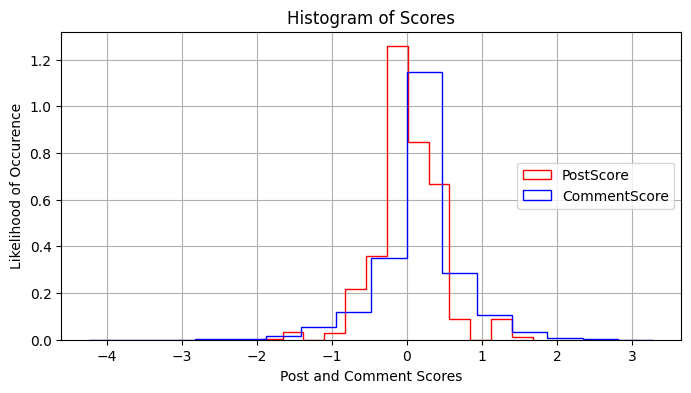

In [20]:
# let's see how our scores came out

n_bins = 16

fig, ax = plt.subplots(figsize=(8,4))

n, bins, patchs = ax.hist(pcss['PostScore'], bins =n_bins, density=True, histtype='step', label='PostScore', color='red')

ax.hist(pcss['CommentScore'], bins =n_bins, density=True, histtype='step', label='CommentScore', color='blue')

ax.grid(True)
ax.legend(loc='right')
ax.set_title('Histogram of Scores')
ax.set_xlabel('Post and Comment Scores')
ax.set_ylabel('Likelihood of Occurence')


plt.show()


Negative Post, Positive Comment:  721
Negative Post, Negative Comment:  613
Positive Post, Negative Comment:  618
Positive Post, Positive Comment:  1576


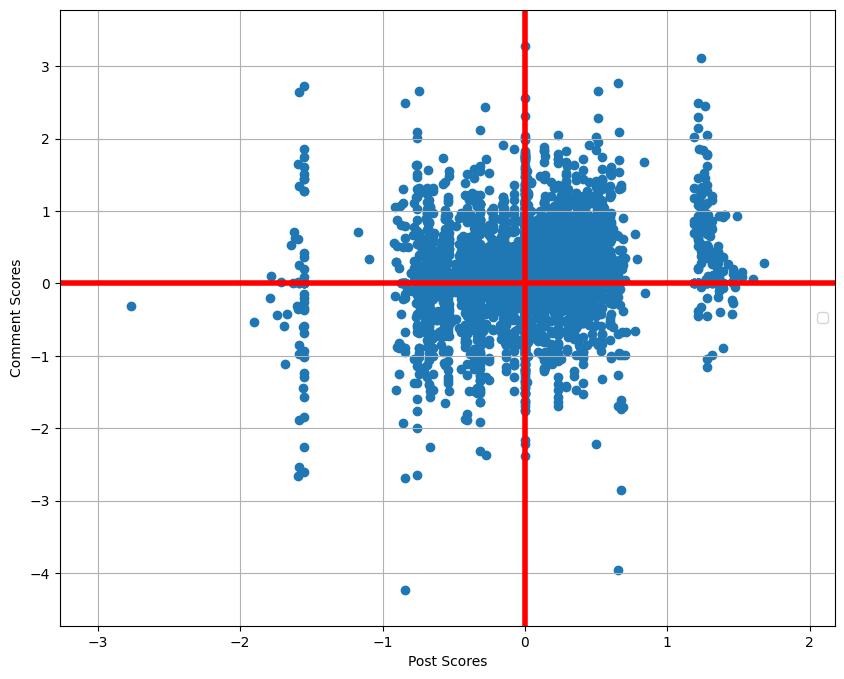

In [21]:
# Now let's visualize this with a scatter plot as well with each post score and corresponding comment score

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(pcss['PostScore'],pcss['CommentScore'])
plt.xlim((min(pcss['PostScore'])-0.5,max(pcss['PostScore'])+0.5))
plt.ylim((min(pcss['CommentScore'])-0.5,max(pcss['CommentScore'])+0.5))
plt.plot([-5,5],[0,0], linewidth=4, color='red')
plt.plot([0,0],[-5,5], linewidth=4, color='red')
ax.grid(visible=True, which='major')
ax.legend(loc='right')
ax.set_xlabel('Post Scores')
ax.set_ylabel('Comment Scores')

print('Negative Post, Positive Comment: ' , len(pcss[pcss['PostScore'].lt(0) & pcss['CommentScore'].gt(0)]))
print('Negative Post, Negative Comment: ',len(pcss[pcss['PostScore'].lt(0) & pcss['CommentScore'].lt(0)]))
print('Positive Post, Negative Comment: ',len(pcss[pcss['PostScore'].gt(0) & pcss['CommentScore'].lt(0)]))
print('Positive Post, Positive Comment: ', len(pcss[pcss['PostScore'].gt(0) & pcss['CommentScore'].gt(0)]))
plt.show()

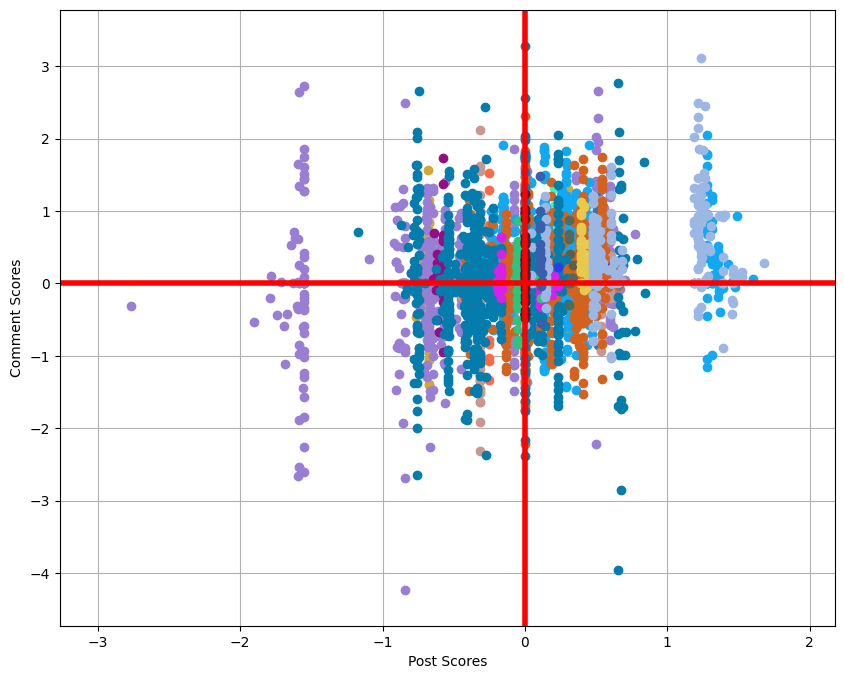

In [22]:
# Now let's see them grouped by company?
fig, ax = plt.subplots(figsize=(10,8))

get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]

for company in companies:
    post_vals = pcss[pcss['company'].str.lower().eq(company.lower())][['company','PostScore','CommentScore']]

    ax.plot(post_vals['PostScore'],post_vals['CommentScore'], marker='o', linestyle='', color = get_colors(1)[0], label=company)
    
plt.xlim((min(pcss['PostScore'])-0.5,max(pcss['PostScore'])+0.5))
plt.ylim((min(pcss['CommentScore'])-0.5,max(pcss['CommentScore'])+0.5))
plt.plot([-5,5],[0,0], linewidth=4, color='red')
plt.plot([0,0],[-5,5], linewidth=4, color='red')
ax.grid(visible=True, which='major')
ax.set_xlabel('Post Scores')
ax.set_ylabel('Comment Scores')
plt.show()

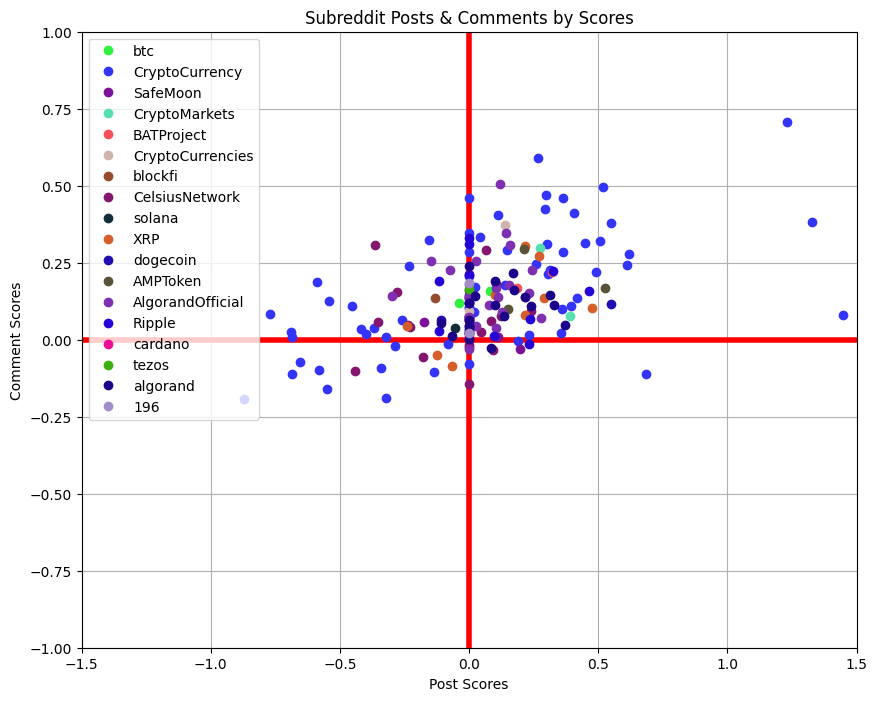

In [23]:
# Now let's see them grouped by company and by post? (We'll use the mean of the comment sentiment as a grouping)
fig, ax = plt.subplots(figsize=(10,8))

plt.xlim((-1.5,1.5))
plt.ylim((-1,1))
plt.plot([-5,5],[0,0], linewidth=4, color='red')
plt.plot([0,0],[-5,5], linewidth=4, color='red')
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]

for sub in subreddit_list:
    post_vals = pcss[pcss['display_name'].str.lower().eq(sub.lower())][['display_name','post_id','PostScore','CommentScore']]
    post_count = len(post_vals)
    grouped_post_vals = post_vals.groupby(['post_id'], as_index=False).agg({'PostScore':'mean','CommentScore':'mean'})
    if post_count > 10:
        ax.plot(grouped_post_vals['PostScore'],grouped_post_vals['CommentScore'], marker='o', linestyle='', color = get_colors(1)[0], label=sub)

ax.legend()
ax.grid(visible=True, which='major')
ax.set_title('Subreddit Posts & Comments by Scores')
ax.set_xlabel('Post Scores')
ax.set_ylabel('Comment Scores')
plt.show()

Interesting to see all those vertical lines. Hypothesis as to why: When companies create posts, they will do so largely in bulk and post to many subreddits. This would make identical post scores regardless of where they posted. But what is interesting is that the comments that are in reply to these posts are distributed across the CommentScore neutral line. Meaning...

People react differently to products/companies in different subreddits! Kinda cool

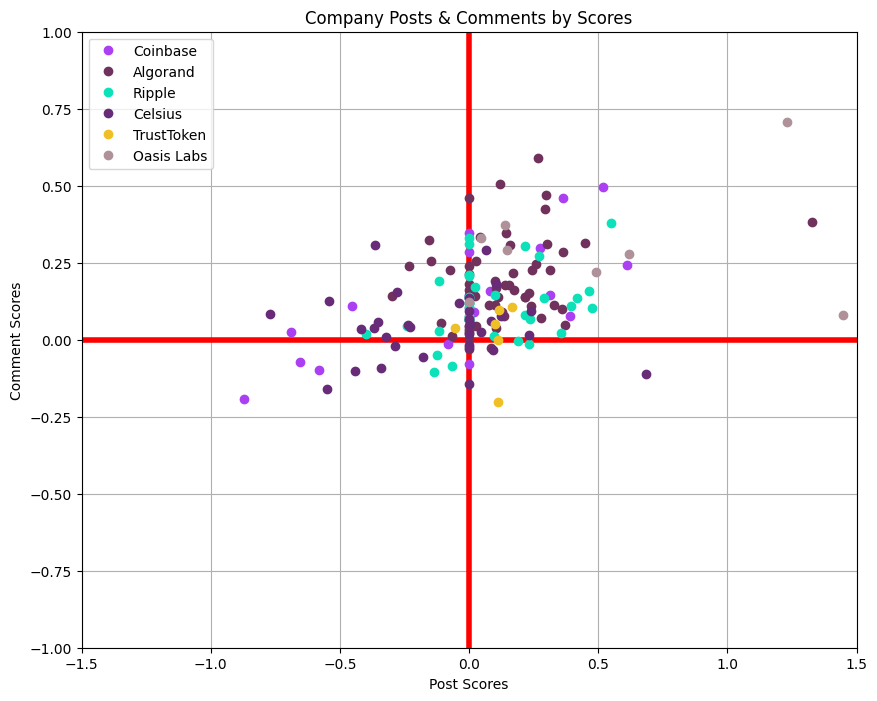

In [25]:
# Now let's see them grouped by company and by post? (We'll use the mean of the comment sentiment as a grouping)
fig, ax = plt.subplots(figsize=(10,8))

plt.xlim((-1.5,1.5))
plt.ylim((-1,1))
plt.plot([-5,5],[0,0], linewidth=4, color='red')
plt.plot([0,0],[-5,5], linewidth=4, color='red')
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]

for company in companies:
    post_vals = pcss[pcss['company'].str.lower().eq(company.lower())][['company','post_id','PostScore','CommentScore']]
    grouped_post_vals = post_vals.groupby(['post_id'], as_index=False).agg({'PostScore':'mean','CommentScore':'mean'})
    if len(grouped_post_vals) > 5:
        ax.plot(grouped_post_vals['PostScore'],grouped_post_vals['CommentScore'], marker='o', linestyle='', color = get_colors(1)[0], label=company)

ax.legend()
ax.grid(visible=True, which='major')
ax.set_title('Company Posts & Comments by Scores')
ax.set_xlabel('Post Scores')
ax.set_ylabel('Comment Scores')
plt.show()

Now that we've used a few useful visualizations, we can start to organize the data into different groupings. 

They are as follows:
- By company
- By post
- By score

Let's see which company has the most posts for us to work with

In [26]:
pcss['company'].value_counts()
# Celcius looks to be our winner here

# In the future, we may want to consider a threshold for posts (e.g. doc.ai is probably not the best)

Algorand                  1494
Celsius                   1202
Ripple                    1013
Coinbase                   893
Oasis Labs                 317
Robinhood                  285
Chainalysis                120
BlockFi                    114
MoonPay                     85
ConsenSys Software Inc      62
TrustToken                  57
STEEM                       57
Paxos                       37
TaxBit                      36
Bloq                        36
ShipChain                   18
Lemonade                    16
Anchorage Digital           11
Filecoin                    10
Nium                         3
Unstoppable Domains          2
doc.ai                       1
Name: company, dtype: int64

In [105]:
algo = pcss[pcss['company'].str.lower().eq('algorand')]
algo.head()
# what we can do is look for the Bi/Tri/Quadgrams that occur and order them by highest sentimentality scores

,company,created,subreddit_id,display_name,public_description,community_reviewed,subscribers,accounts_active,post_id,title,...,upvote_ratio_scaled,total_awards_received_scaled,num_comments_scaled,num_crossposts_scaled,awards_scaled,comment_score_scaled,reply_score_scaled,max_depth_scaled,PostScore,CommentScore
id,,,,,,,,,,,,,,,,,,,,,
2wlj3-xj7yhh-ip74zlh,Algorand,1.663678e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5601587.0,None,xj7yhh,The Algorand shillers have been relentless abo...,...,2.105263,4.090909,6.454874,0.909091,0.000000,0.821622,0.271140,1.538462,0.144964,0.437369
2wlj3-xj7yhh-ip7giv7,Algorand,1.663678e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5601587.0,None,xj7yhh,The Algorand shillers have been relentless abo...,...,2.105263,4.090909,6.454874,0.909091,0.000000,0.902703,0.344669,1.538462,0.145780,0.293313
2wlj3-xj7yhh-ip6ujn1,Algorand,1.663678e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5601587.0,None,xj7yhh,The Algorand shillers have been relentless abo...,...,2.105263,4.090909,6.454874,0.909091,0.000000,1.145946,0.422794,3.076923,0.155595,0.000000
2wlj3-xj7yhh-ip752fc,Algorand,1.663678e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5601587.0,None,xj7yhh,The Algorand shillers have been relentless abo...,...,2.105263,4.090909,6.454874,0.909091,1.333333,1.302703,0.767463,1.538462,0.157159,-0.359189
2wlj3-xj7yhh-ip6xrdv,Algorand,1.663678e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5601587.0,None,xj7yhh,The Algorand shillers have been relentless abo...,...,2.105263,4.090909,6.454874,0.909091,10.000000,4.448649,2.587316,3.076923,0.237223,0.106698


In [28]:
# we're just going to tackle the 'thread' column here, but this will be easily replicated with the 'title' and 'selftext' columns
algo_threads = algo[~algo['thread'].str.contains(r'automoderator|bot|action performed|deleted|amp', '', flags=re.IGNORECASE)]['thread'].dropna().unique().tolist()

ct = ''.join(algo_threads).lower()

stoplists = nltk.corpus.stopwords.words()

text = nltk.word_tokenize(ct)
text1 = [w for w in text if w.lower() not in stoplists and w.isalpha()]

# then we can create a text object to use for the Trigram Finder
text = nltk.Text(text1)
finder_bi = nltk.collocations.BigramCollocationFinder.from_words(text)
finder_tri = nltk.collocations.TrigramCollocationFinder.from_words(text)
finder_quad = nltk.collocations.QuadgramCollocationFinder.from_words(text)
bigram = finder_bi.ngram_fd.most_common(50)
trigram = finder_tri.ngram_fd.most_common(50)
quadgram = finder_quad.ngram_fd.most_common(50)
bigram

[(('bear', 'market'), 27),
 (('world', 'cup'), 23),
 (('state', 'proofs'), 20),
 (('gigabyteio', 'gif'), 19),
 (('silvio', 'micali'), 14),
 (('bull', 'run'), 13),
 (('long', 'term'), 11),
 (('bull', 'market'), 11),
 (('transaction', 'fees'), 10),
 (('smart', 'contract'), 10),
 (('great', 'news'), 10),
 (('governance', 'rewards'), 9),
 (('algorand', 'foundation'), 9),
 (('real', 'world'), 9),
 (('active', 'users'), 8),
 (('years', 'ago'), 8),
 (('accelerated', 'vesting'), 8),
 (('love', 'algorand'), 8),
 (('market', 'cap'), 8),
 (('https', 'https'), 8),
 (('make', 'money'), 7),
 (('pera', 'wallet'), 7),
 (('governance', 'period'), 6),
 (('algorand', 'blockchain'), 6),
 (('fast', 'cheap'), 6),
 (('algorand', 'algorand'), 6),
 (('algorand', 'ecosystem'), 5),
 (('crypto', 'space'), 5),
 (('time', 'buy'), 5),
 (('cherry', 'picked'), 5),
 (('past', 'months'), 5),
 (('price', 'action'), 5),
 (('buy', 'gigabyteio'), 5),
 (('algorand', 'top'), 5),
 (('big', 'things'), 5),
 (('participate', 'gov

In [33]:
# now that we have all the important bi/tri/quadgrams, we can find their corresponding comments/posts
bigram_limit = 3
trigram_limit = 2
quadgram_limit = 2


bigrams = [b[0] for b in bigram if b[1] > bigram_limit]
trigrams = [t[0] for t in trigram if t[1] > trigram_limit]
quadgrams = [q[0] for q in quadgram if q[1] > quadgram_limit]

grams = bigrams + trigrams + quadgrams

gv = []

for gram in grams:
    gram_values = {}
    g = '.*'.join(gram)
    cg_thread = algo[algo['thread'].str.contains(g,flags=re.IGNORECASE)]
    gram_values['gram'] = gram
    gram_values['average_comment_score'] = cg_thread['CommentScore'].mean()
    gram_values['associated_titles'] = [cg_thread['title'].to_list()]
    gram_values['threads'] = [cg_thread['thread'].to_list()]
    gv.append(gram_values)


gram_df = pd.DataFrame(gv)
gram_df = gram_df.sort_values(by=['average_comment_score'], ascending=False)
gram_df

# we are doing some aggregation here that would benefit from some further expansion
# e.g. see within the gram, the range of comment scores.
# We'll try tagging all comments with their grams instead to see if we can get some interesting groups

,gram,average_comment_score,associated_titles,threads
10,"(great, news)",0.890740,"[[With the new upgrade, Algorand now has &amp;...",[[reshail_raza: Now should we talk about centr...
54,"(ible, city, nft)",0.505926,"[[[AMA] Vendible, a privacy-preserving identit...",[[PhoandRamen: Since you want to make your sol...
49,"(participating, governance)",0.442666,[[The Algorand shillers have been relentless a...,[[pbjclimbing: The Tinyman hack had a very neg...
24,"(fast, cheap)",0.412640,[[The Algorand shillers have been relentless a...,[[External_Kick_2273: As long as it exists fo...
60,"(stake, skybridge, capital)",0.406030,"[[FTX now supports Algorand USDC!, FTX now sup...",[[UsernameIWontRegret: This is especially huge...
...,...,...,...,...
46,"(believe, algorand)",0.135811,[[The Algorand shillers have been relentless a...,[[timeisall7: **Inflation** \nYou deliberatel...
12,"(algorand, foundation)",0.129535,[[The Algorand shillers have been relentless a...,[[MattKozFF: There's a fixed total of 10B Algo...
56,"(buy, gigabyteio, gif)",0.120654,"[[Did you know that Silvio Micali, the founder...",[[Missmilster: Cool facts. Thanks and yay Algo...
31,"(price, action)",0.083076,[[The Algorand shillers have been relentless a...,[[practiceperfect111: The price action ain't s...


In [114]:
# tagging comments in the algo dataframe


#new collumn for tagging
tags = []
for id, row in algo.iterrows():
    tag = {}
    tag['id'] = id
    tag['tags'] = ''
    for gram in grams:
        g = re.compile('.*'.join(gram).lower())
        if g.search(row['thread'].lower()):
            if tag['tags'] == '':
                tag['tags'] = (' - '.join(gram))
            else:
                tag['tags'] += ' & ' + (' - '.join(gram))
    if len(tag['tags']) == 0:
        tag['tags'] = ''
    
    tags.append(tag)

t = pd.DataFrame(tags)
algo_tagged = algo.merge(t, how='outer', on='id')

# example of sorting by a particular tag

algo_tagged[algo_tagged['tags'].str.contains(' - '.join(grams[2]))][['title','selftext','thread']]



,title,selftext,thread
12,The Algorand shillers have been relentless abo...,The Algorand shillers have been relentless abo...,timeisall7: **Inflation** \nYou deliberately ...
178,"With the new upgrade, Algorand now has &amp;gt...",I think we can all agree that tps numbers can ...,LankeeM9: At the cost of centralization you do...
180,"With the new upgrade, Algorand now has &amp;gt...",I think we can all agree that tps numbers can ...,Bigjukes_inc: Don't forget about state proofs....
259,"Zero downtime, no forking, 4.4 second determin...",Algorand Metrics: [metrics.Algorand.org](http...,ThiccMangoMon: It's been a crazy year for algo...
303,I've compiled a list of real-world usage of th...,1) Former PayPal and Ripple employees(Jim Nguy...,Altruistic-Pipe-2761: ALGO is one of the top L...
377,I've compiled a list of real-world usage of th...,1) Former PayPal and Ripple employees(Jim Nguy...,Sour-Bitter-Confused: Excited about next week:...
457,Algorand Deploys 'State Proof' Tech as Part of...,,nevertoolate02: I don't want to make any big p...
458,Algorand Deploys 'State Proof' Tech as Part of...,,MattKozFF: Silvio Micali acknowledging *State ...
463,Algorand Deploys 'State Proof' Tech as Part of...,,MattKozFF: &amp;gt;**The Big Picture** \n&amp...
469,Algorand Deploys 'State Proof' Tech as Part of...,,slipcovergl: Certainly one of the biggest cryp...


# An example from a higher sentiment post associated with Algorand
#### This pulls all the posts associated with "Great News" in the comment
#### This gives us the potential to start grouping posts based on 'topics', and filtered on sentiment
#### this will be something that needs to be proofed repeatedly (espcially with reddit-related jargon)

**Post Titles**

- "I've compiled a list of real-world usage of the Algorand blockchain. Countries and corporations all around the world are utilizing Algorand's security, speed, and decentralization to empower their citizens, businesses, and institutions. Take a look at this list, this is what adoption looks like."

- "Algorand Deploys 'State Proof' Tech as Part of Most Recent Upgrade,L2 solution makes Cardano, Algorand network interoperable"

- "L2 solution makes Cardano, Algorand network interoperable"

- "Algorand v3.9 Major Update details - State Proofs, Higher throughput, Faster finality,FTX now supports Algorand USDC."

- "Vestige is partnering up with Banxa to provide on-ramp and off-ramp solutions to Algorand DeFi"

**Associated Comments**

- Wafer_Fearless: Great news. I do like me some ALGO --- 
    - gigabyteIO: ![gif](giphy|3o7WIxPr8EvjpDlfws|downsized),

- kirtash93: I love to see that ALGO is always improving. Great news!,

- VeludoVeludo: Great news!,evoxyseah: Great news, make friends not enemy!,

- kirtash93: Great news! ALGO is one of my favorite projects and I love their governance system.,

- Roberto9410: This is seriously big news, and might be flying under the radar a bit - the visibility is great for USDCa, and given the speed and ease of use I think a lot more traffic will come to algorand --- 
    - Nows_a_good_time: USDCa can be so good. Just need more platforms that use it, exactly like this. Good to see it.. 
        - gigabyteIO: Agreed. I think a snowball effect is going to happen around Algorand, it's so superior than many in the top 10 and deserves to be in the top 5..          
            - Unfair-Newspaper-546: but price did not move?. 
                - Viper_NZ: Price went down. 
                    - Unfair-Newspaper-546: it did.. so are we buying?. 
                        - Viper_NZ: The trick is to wait until it goes up first, then buy..     
                            - Unfair-Newspaper-546: ill try
                            
                            
- dk_cam: Here's to new onramping options for the community ! Great news. And this sounds like it comes with great visibility for new people to algorand through the Banxa platform. Well done